In [1]:
library(keras)
library(keras3)
library(magick)
library(viridis)
library(tensorflow)

Registered S3 methods overwritten by 'keras3':
  method                               from 
  as.data.frame.keras_training_history keras
  plot.keras_training_history          keras
  print.keras_training_history         keras
  r_to_py.R6ClassGenerator             keras


Attaching package: 'keras3'


The following objects are masked from 'package:keras':

    %<-active%, %py_class%, activation_elu, activation_exponential,
    activation_gelu, activation_hard_sigmoid, activation_linear,
    activation_relu, activation_selu, activation_sigmoid,
    activation_softmax, activation_softplus, activation_softsign,
    activation_tanh, adapt, application_densenet121,
    application_densenet169, application_densenet201,
    application_efficientnet_b0, application_efficientnet_b1,
    application_efficientnet_b2, application_efficientnet_b3,
    application_efficientnet_b4, application_efficientnet_b5,
    application_efficientnet_b6, application_efficientnet_b7,
    application_inception_re

In [2]:
setwd("D:/Projects/Face recognition/faces")

In [3]:
model <- load_model("callbacks/best_7.keras")

In [12]:
test_images <- sample(paste(getwd(), "crop_train/user", dir("crop_train/user"), sep = "/"), 25)

In [5]:
test_images <- paste(getwd(), "train/user/user_001.jpg", sep = "/")

In [13]:
load_and_process <- function(img) {
        img <- img %>%
                tf$io$read_file() %>%
                tf$io$decode_png(channels = 3) %>%
                tf$image$resize(as.integer(c(300, 300))) %>%
                tf$expand_dims(0L)

        img <- (img / 127.5) - 1
        return(img)
}

In [14]:
make_gradcam_heatmap <- function(img_array, model, y, test_images) {
    grad_model <- keras_model(
        model$input, c(model$get_layer("block14_sepconv2_act")$output, model$output)
    )


    with(
        tf$GradientTape() %as% tape,
        {
            c(last_conv_layer_output, preds) %<-% grad_model(img_array)

            pred_index <- tf$argmax(preds[1, ])

            class_channel <- preds[, pred_index]
        }
    )

    grads <- tape$gradient(class_channel, last_conv_layer_output)

    pooled_grads <- k_mean(grads, axis = c(1, 2, 3))

    last_conv_layer_output <- last_conv_layer_output[1, , , ]

    heatmap <- last_conv_layer_output %*% pooled_grads[, tf$newaxis]

    heatmap <- tf$squeeze(heatmap)

    heatmap <- tf$maximum(heatmap, 0) / tf$math$reduce_max(heatmap)

    heatmap <- k_eval(heatmap)

    write_heatmap <- function(heatmap, filename, width = 640, height = 480,
                              bg = "white", col = terrain.colors(12)) {
        png(filename, width = width, height = height, bg, units = "px")

        op <- par(mar = c(0, 0, 0, 0))

        on.exit(
            {
                par(op)
                dev.off()
            },
            add = TRUE
        )

        rotate <- function(x) t(apply(x, 2, rev))

        image(rotate(heatmap), axes = FALSE, asp = 1, col = col)
    }

    write_heatmap(heatmap, paste("img_heatmap_", y, ".png", sep = ""))

    image <- image_read(test_images)

    info <- image_info(image)

    geometry <- sprintf("%dx%d!", info$width, info$height)

    pal <- col2rgb(viridis(20), alpha = TRUE)
    alpha <- floor(seq(0, 255, length = ncol(pal))) * 0.8
    pal_col <- rgb(t(pal), alpha = alpha, maxColorValue = 255)

    write_heatmap(heatmap, paste("img_overlay_", y, ".png", sep = ""),
        width = 14, height = 14, bg = NA, col = pal_col
    )

    return(geometry)
}

Warning message in png(filename, width = width, height = height, bg, units = "px"):
"NAs introduced by coercion"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"'width=14, height=14' are unlikely values in pixels"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"NAs introduced by coercion"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"'width=14, height=14' are unlikely values in pixels"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"NAs introduced by coercion"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"'width=14, height=14' are unlikely values in pixels"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"NAs introduced by coercion"
Warning message in png(filename, width = width, height = height, bg, units = "px"):
"'width=14, height=14' are unlikely values in pixe

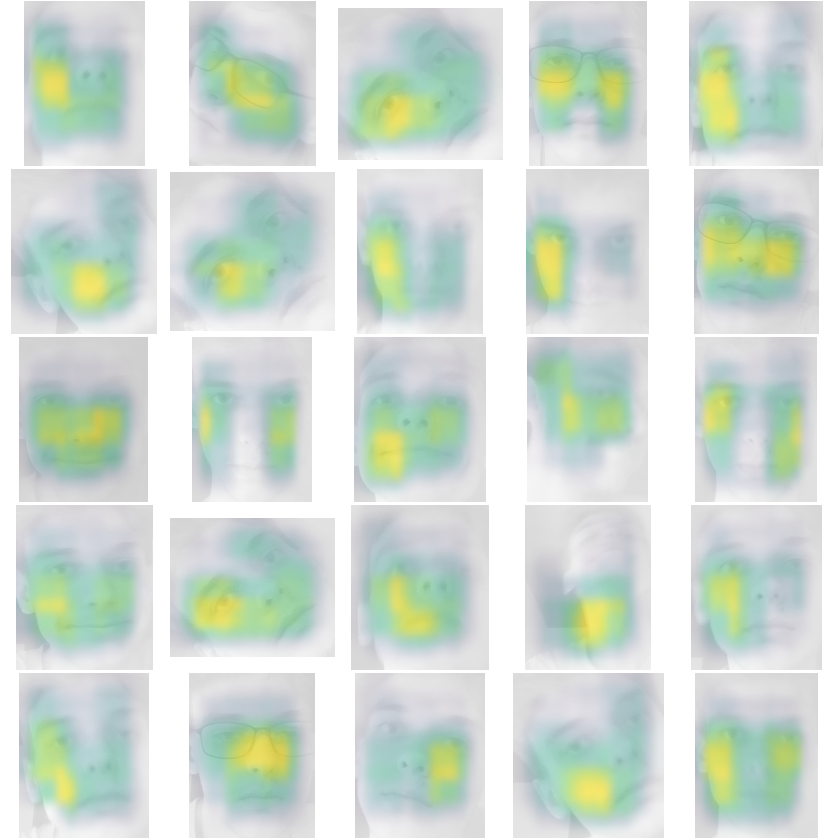

In [16]:
par(mfrow = c(5, 5), mar = c(rep(0.1, 4)))

y <- 1

while (y <= length(test_images)) {
    image_temp <- load_and_process(test_images[y])

    geom_temp <- make_gradcam_heatmap(image_temp, model, y, test_images[y])

    image_temp <- image_read(paste("img_overlay_", y, ".png", sep = ""))

    image_temp <- image_resize(image_temp, geom_temp, filter = "quadratic")

    image_temp <- image_composite(
        image = image_temp,
        composite_image = image_convert(image_read(test_images[y]), colorspace = "gray"),
        operator = "blend",
        compose_args = "20"
    )

    plot(image_temp)
    y <- y + 1
}